Input data:
-	Artificial data as created by Cole

Exploratory:
-	Plot the data
-	Plot a Lomb-Scargle periodogram

Processing:
-	Compose a Gaussian Process from a reasonable guess of kernels
-	Learn the hyperparameters of each kernels by search
-	Substract the model from the data
-	Test that the remainder is white noise(?)
-	Predict gaps using the model?

Output:
-	Plot the data
-	Take X samples of final model and visualize
-	Show the model applied to the data with confidence intervals

Adapted in notebook 2:
- use linearily spaced test points

Difference compared to cl_2:
- Celerite theano
- RotationTerm
https://gallery.exoplanet.codes/tutorials/stellar-variability/

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Use Celerite v2
import celerite2
from celerite2 import terms

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
# Print first and last lines of the dataset
#df.style.format('{:.16f}')
#df

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

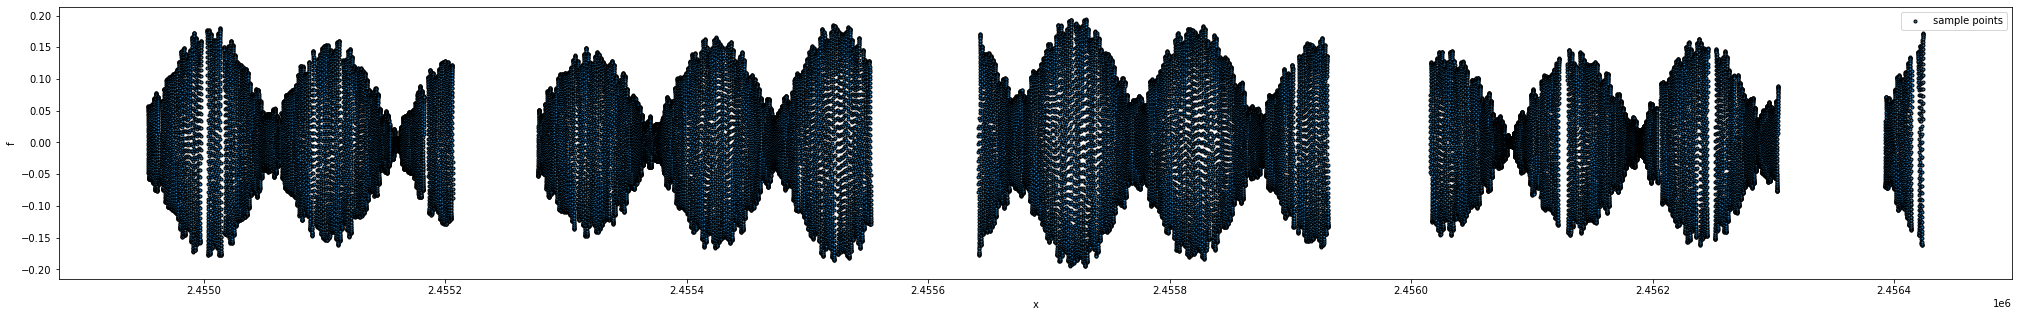

In [6]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

### Zoomed in on the first N observations

In [7]:
N=int(X.shape[0]/4)
N

12993

In [8]:
train_x=X[:N]
train_y=Y[:N]

### Let’s get an estimate of the rotation period using the Lomb-Scargle periodogram:

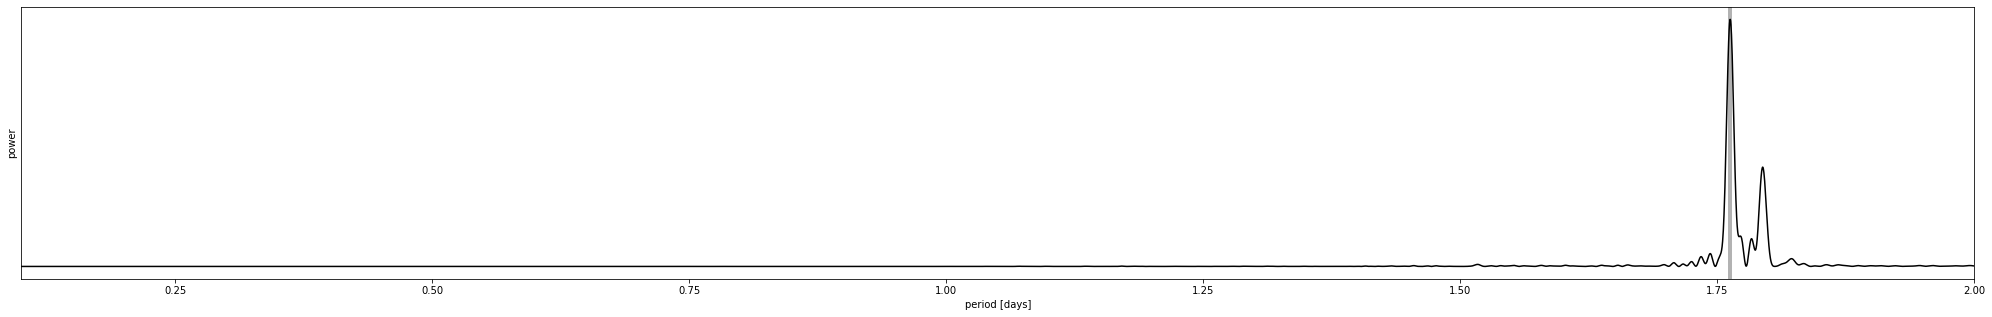

In [26]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    train_x, train_y, max_peaks=1, min_period=0.1, max_period=2.0, samples_per_peak=50
)

plt.figure(figsize=(35, 5))

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

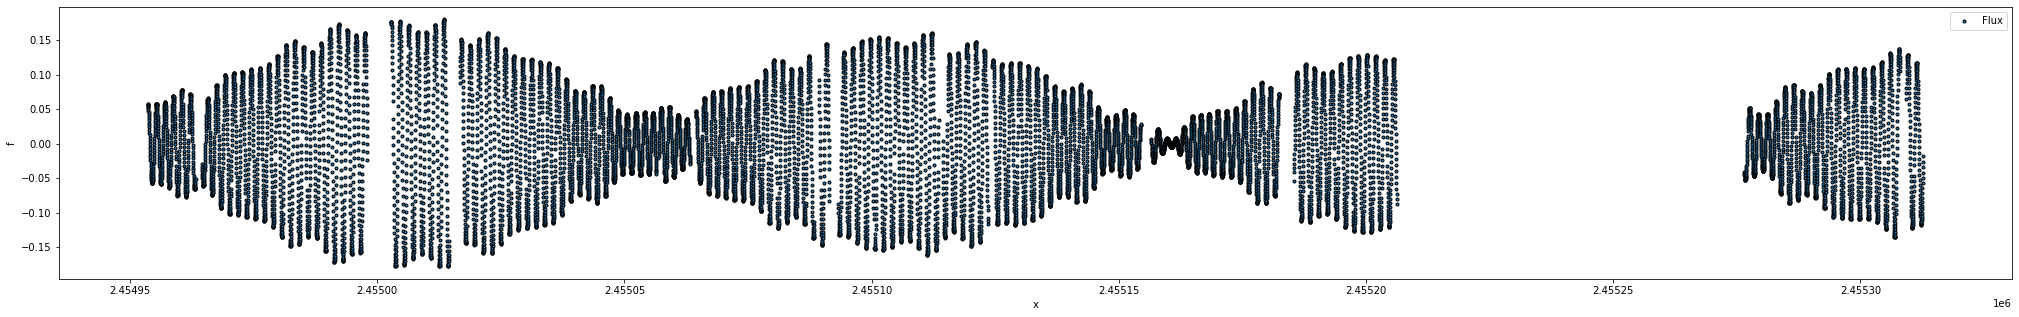

In [9]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(train_x, train_y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [22]:
yerr=1.0

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(peak["period"]), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=train_x,
        diag=yerr ** 2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=train_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(train_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -18586.047650811488 -> -12094.012452833249


Plot the maximum a posteriori model prediction.

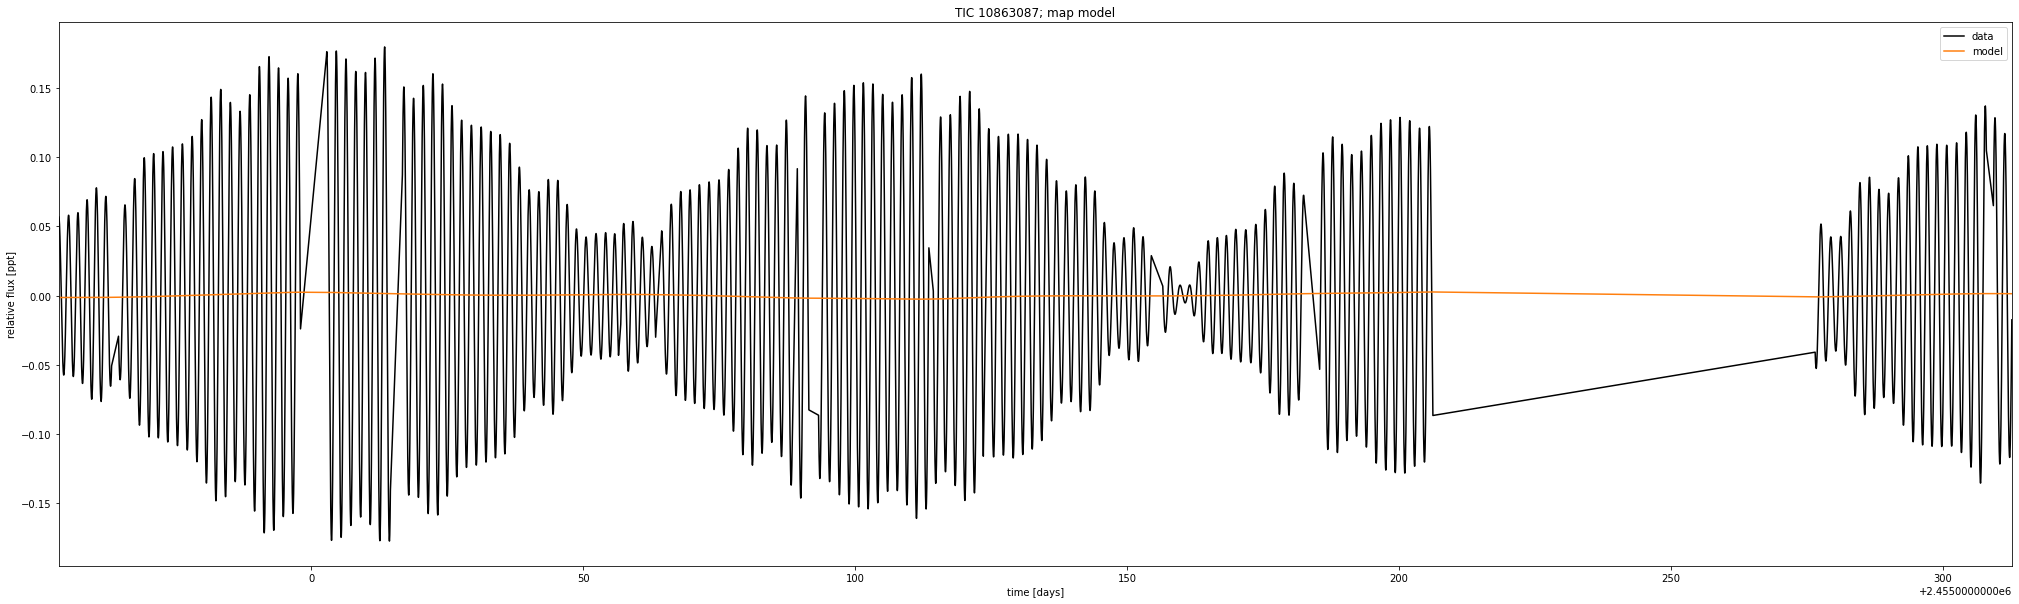

In [25]:
plt.figure(figsize=(35, 10))

plt.plot(train_x, train_y, "k", label="data")
plt.plot(train_x, map_soln["pred"], color="C1", label="model")
plt.xlim(train_x.min(), train_x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087; map model")

In [13]:
# Predict evenly spaced points on our time-axis
test_x = np.linspace(train_x.min(),train_x.max(),N)

In [14]:
pred_y, variance = gp.predict(train_y, t=test_x, return_var=True)

In [15]:
def plot_prediction(mu, variance):
    plt.plot(train_x, train_y, ".", mew=1, linewidth=1, mec="black")
#    plt.plot(train_x, train_y, "k", lw=1.5, alpha=0.8, label="data")
#    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    sigma = np.sqrt(variance)

    plt.plot(test_x, mu, label="prediction")
    plt.fill_between(test_x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
#    plt.xlim(0, 10)
#    plt.ylim(-2.5, 2.5)
    plt.legend()

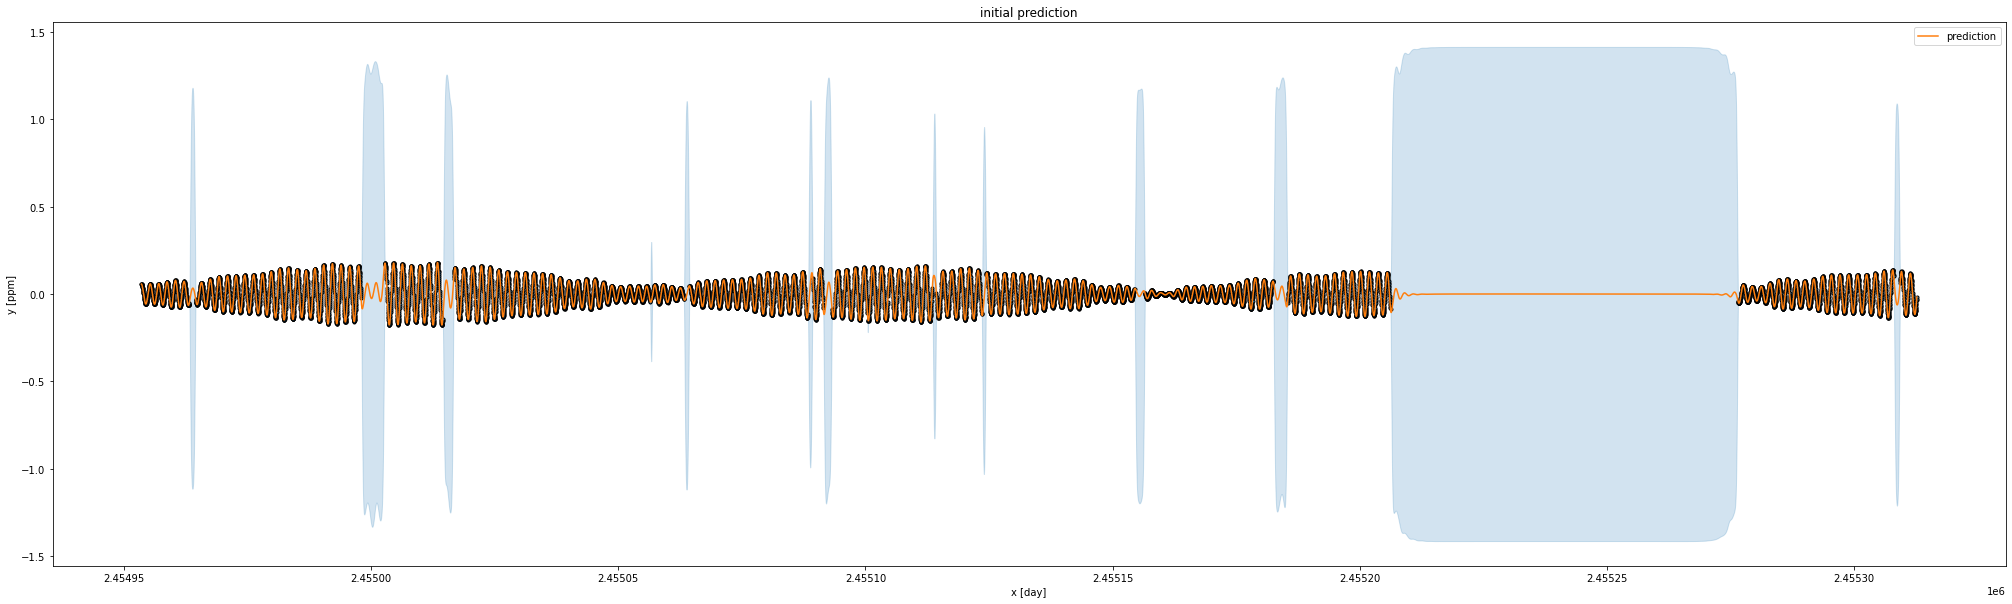

In [16]:
plt.figure(figsize=(35, 10))
plt.title("initial prediction")
plot_prediction(pred_y, variance)

In [22]:
residuals = train_y-pred_y

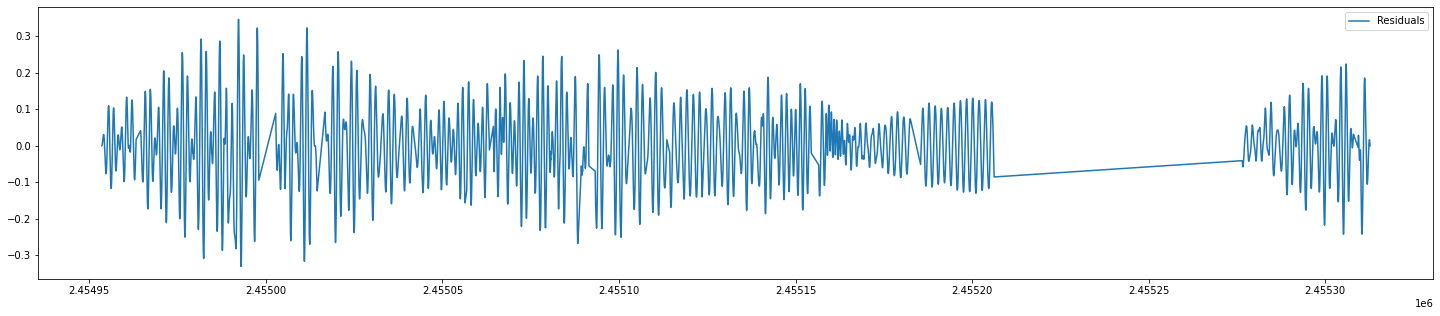

In [24]:
# Plot GP residuals
plt.figure(figsize=(25, 5))
plt.plot(train_x, residuals, "-")
plt.legend(labels=["Residuals"])

Maximum likelihood

In [30]:
from scipy.optimize import minimize

yerr=1

def set_params(params, gp, t):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(t, diag=yerr ** 2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp, t, y):
    gp = set_params(params, gp, t)
    return -gp.log_likelihood(y)


initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,train_x, train_y))
opt_gp = set_params(soln.x, gp, train_x)
soln

      fun: 11979.05658220092
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0003638,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 25
     njev: 27
   status: 0
  success: True
        x: array([ 1.10397876e-04, -1.67939565e+01, -5.15623663e-01,  5.04831854e+00,
       -1.83444427e+01,  5.35393756e+00, -1.77546949e+01])

In [37]:
plt.figure()
plt.title("maximum likelihood psd")
plot_psd(opt_gp)

In [ ]:
pred_y, variance = opt_gp.predict(train_y, t=test_x, return_var=True)

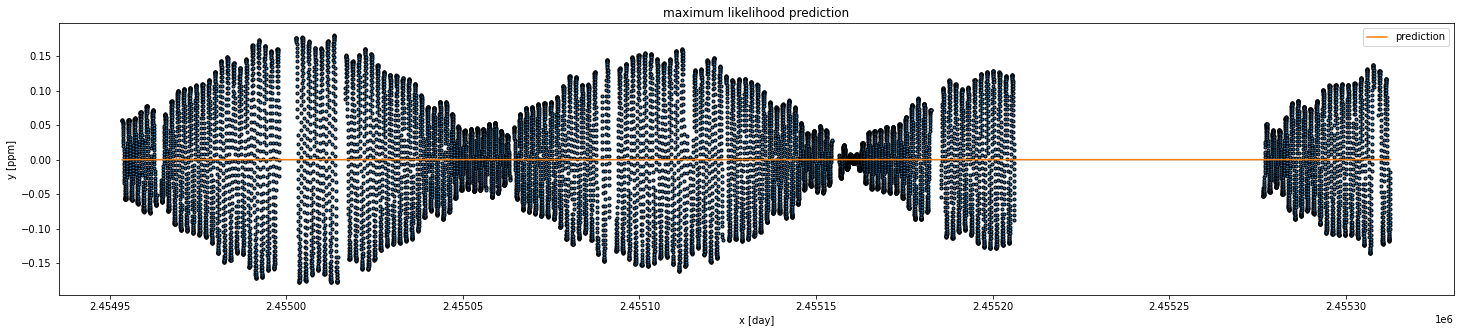

In [36]:
plt.figure(figsize=(25, 5))
plt.title("maximum likelihood prediction")
plot_prediction(pred_y, variance)

As I also saw with the GPy and GPyTorch, the longer I optimize, the worse the results will be.